### Figure

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-02-28 17:01:10.103966: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 17:01:10.324783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 17:01:10.324844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 17:01:10.354350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 17:01:10.419361: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import pandas as pd
import numpy as np
import os

from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os

figure = "circle"
path = "../../Figure_project/data/" + figure + "/"

for idx, n in enumerate(os.listdir(path)):
    new_name = path + figure + "." + str(idx) + ".jpg"
    os.rename(path + n, new_name)
    
os.listdir(path)
    

['circle.38.jpg',
 'circle.20.jpg',
 'circle.36.jpg',
 'circle.42.jpg',
 'circle.9.jpg',
 'circle.8.jpg',
 'circle.11.jpg',
 'circle.47.jpg',
 'circle.52.jpg',
 'circle.41.jpg',
 'circle.21.jpg',
 'circle.45.jpg',
 'circle.39.jpg',
 'circle.29.jpg',
 'circle.44.jpg',
 'circle.55.jpg',
 'circle.51.jpg',
 'circle.32.jpg',
 'circle.23.jpg',
 'circle.40.jpg',
 'circle.37.jpg',
 'circle.43.jpg',
 'circle.54.jpg',
 'circle.58.jpg',
 'circle.53.jpg',
 'circle.50.jpg',
 'circle.46.jpg',
 'circle.48.jpg',
 'circle.49.jpg',
 'circle.59.jpg',
 'circle.56.jpg']

### 고유 식별자를 만들기 위해 이름 변경하기

In [3]:
import os

labels = []
file_id = []

path = "../../Figure_project/data/train/"
full_names = sorted(os.listdir(path))

for each in full_names:
    labels.append(each.split('.')[0])
    file_id.append(each.split('.')[1])
    
unique_id = [f"{label}_{id}" for label, id in zip(labels, file_id)]


In [4]:
print(len(labels))

180


In [5]:
print(len(labels))

180


In [6]:
print(len(labels))

180


### 샘플 보기

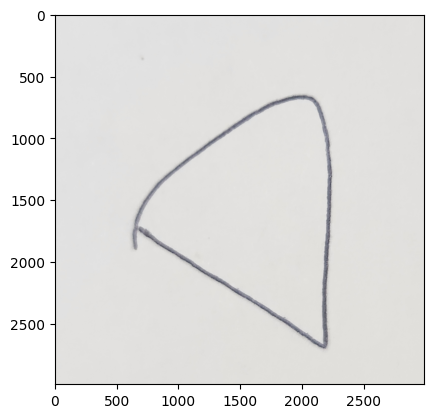

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

sample = random.choice(full_names)
image = mpimg.imread(path + sample)
plt.imshow(image)
plt.show()

In [8]:
sample = random.choice(full_names)
image = mpimg.imread(path + sample)
image.shape

(2992, 2992, 3)

-> 크기가 다 다르다

In [31]:
min_height = float('inf')
min_width = float('inf')
max_height = float('-inf')
max_width = float('-inf')

for sample in full_names:
    image_path = os.path.join(path, sample)
    image = mpimg.imread(image_path)
    
    height, width = image.shape[:2]  # 채널 정보는 제외
    
    if height < min_height:
        min_height = height
    if width < min_width:
        min_width = width
    if height > max_height:
        max_height = height
    if width > max_width:
        max_width = width
        
print(f"가장 작은 이미지 크기 {min_height}x{min_width}")
print(f"가장 큰 이미지 크기 {max_height}x{max_width}")

가장 작은 이미지 크기 1920x1920
가장 큰 이미지 크기 3024x3024


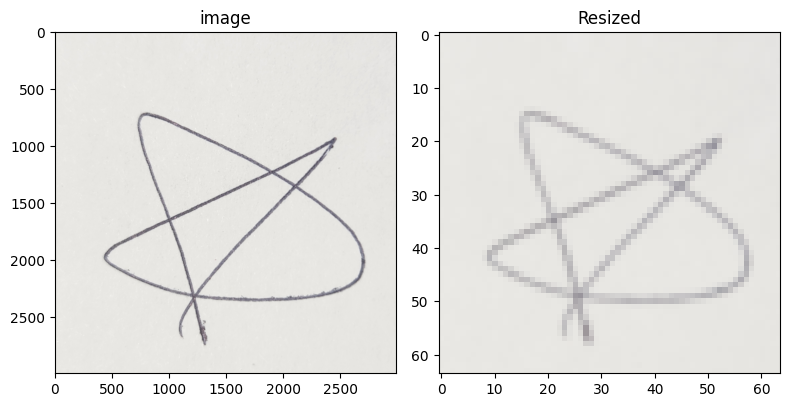

In [9]:
from skimage.transform import resize

sample = random.choice(full_names)
image = mpimg.imread(path + sample)

resized = resize(image, (64, 64, 3))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("image")
ax[1].imshow(resized, cmap=plt.cm.gray)
ax[1].set_title("Resized")

fig.tight_layout()
plt.show()

### 모든 파일 64 x 64로 리사이즈

In [10]:
from tqdm.notebook import tqdm
from skimage.color import rgb2gray
import numpy as np

images = []

for file in tqdm(full_names):
    image = mpimg.imread(path + file)
    images.append(resize(image, (64, 64, 3)))
    
images = np.array(images)

  0%|          | 0/180 [00:00<?, ?it/s]

In [11]:
images.shape, labels[:3]

((180, 64, 64, 3), ['circle', 'circle', 'circle'])

array 형식의 64x64 데이터셋 완성 !

    우선 레이블링

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(labels)
labels_encoded = encoder.transform(labels)
labels_encoded[59:62], encoder.classes_

(array([0, 1, 1]), array(['circle', 'star', 'triangle'], dtype='<U8'))

In [59]:
from tensorflow.keras.utils import to_categorical

labels_one_hot = to_categorical(labels_encoded)

-> label_encoded로 계산된 세 레이블이 1('star') 또는 0('circle')이다

    one hot encoding과 비슷한 역할을 해주는 sparse_categorical_crossentropy이용!
    one hot encoding을 하려면 레이블링 하고, 카테고리화해서 categorical_crossentropy하면 됨

=> 근데 두 개 다 성능 비슷 ~

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),   # 64x64
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')      # 원, 별, 세모
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000001)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # 레이블이 정수 형태로 인코딩 되어있을 때 사용하는 손실함수
              metrics=['accuracy'])

### 훈련 세트와 테스트 세트로 나누기

In [17]:
from sklearn.model_selection import train_test_split

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# 정규화 0-1사이
# 데이터 정규화
x_train, x_test = x_train / 255.0, x_test / 255.0

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               6291968   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 6293507 (24.01 MB)
Trainable params: 6293507 (24.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
import time

start_time = time.time()
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                 epochs=1000, batch_size=10, verbose=1)

print('Fit time :', time.time() - start_time)

Epoch 1/1000


2024-02-28 17:16:10.361155: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb6c8003b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 17:16:10.361175: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-28 17:16:10.369087: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-28 17:16:10.718624: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1709108170.793218   15396 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 3s 14ms/step - loss: 1.1223 - accuracy: 0.3125 - val_loss: 1.1007 - val_accuracy: 0.3333
Epoch 2/1000
15/15 [==============================] - 0s 5ms/step - loss: 1.1000 - accuracy: 0.3333 - val_loss: 1.1005 - val_accuracy: 0.3333
Epoch 3/1000
15/15 [==============================] - 0s 5ms/step - loss: 1.1000 - accuracy: 0.3333 - val_loss: 1.1000 - val_accuracy: 0.3333
Epoch 4/1000
15/15 [==============================] - 0s 5ms/step - loss: 1.0990 - accuracy: 0.3333 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 5/1000
15/15 [==============================] - 0s 6ms/step - loss: 1.0988 - accuracy: 0.3333 - val_loss: 1.0997 - val_accuracy: 0.3333
Epoch 6/1000
15/15 [==============================] - 0s 6ms/step - loss: 1.0990 - accuracy: 0.2917 - val_loss: 1.0998 - val_accuracy: 0.3056
Epoch 7/1000
15/15 [==============================] - 0s 5ms/step - loss: 1.0987 - accuracy: 0.3403 - val_loss: 1.1003 - val_accuracy: 0.3056
Epoch 8/1000
15/15

In [20]:
import time

start_time = time.time()
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                 epochs=1000, batch_size=10, verbose=1)

print('Fit time :', time.time() - start_time)

Epoch 1/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.9023 - accuracy: 0.6667 - val_loss: 0.9692 - val_accuracy: 0.4722
Epoch 2/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.9001 - accuracy: 0.6667 - val_loss: 0.9650 - val_accuracy: 0.5278
Epoch 3/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.9041 - accuracy: 0.6597 - val_loss: 0.9703 - val_accuracy: 0.5000
Epoch 4/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.9010 - accuracy: 0.6667 - val_loss: 0.9640 - val_accuracy: 0.5556
Epoch 5/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.9094 - accuracy: 0.6736 - val_loss: 0.9647 - val_accuracy: 0.5278
Epoch 6/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.9045 - accuracy: 0.6667 - val_loss: 0.9678 - val_accuracy: 0.4722
Epoch 7/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.9017 - accuracy: 0.6597 - val_loss: 0.9634 - val_accuracy: 0.5556
Epoch 

accuracy는 올라갔으나..

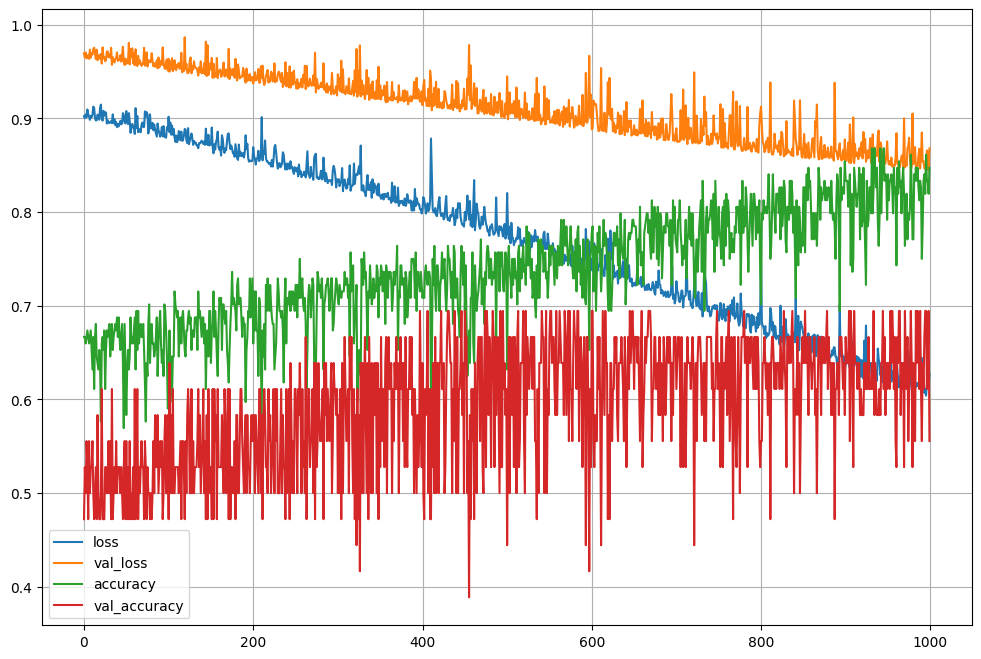

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12, 8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)
    
plt.legend()
plt.grid()
plt.show()

이상한 그래프가 나왔다.

In [84]:
score = model.evaluate(x_test, y_test)
print("Test loss : ", score[0])
print("Test accuracy : ", score[1])

2/2 [==============================] - 0s 3ms/step - loss: 0.9249 - accuracy: 0.6389
Test loss :  0.9249477386474609
Test accuracy :  0.6388888955116272


테스트세트도 과적합 

그래서 ! 증강을 했다.

### 다시 ! 훈련, 테스트, 검증 데이터 나누기

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(labels)
labels_encoded = encoder.transform(labels)
labels_encoded[59:62], encoder.classes_

(array([0, 1, 1]), array(['circle', 'star', 'triangle'], dtype='<U8'))

In [25]:
from sklearn.model_selection import train_test_split

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# 훈련 세트를 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 정규화 0-1사이
# 데이터 정규화
X_train, X_test, X_val = X_train / 255.0, X_test / 255.0, X_val / 255.0

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               6291968   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 6293507 (24.01 MB)
Trainable params: 6293507 (24.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### train 데이터 증강

In [27]:
train_datagen = ImageDataGenerator(
    rotation_range= 15,
    horizontal_flip= True,
    vertical_flip = True,
    brightness_range=[0.8, 1.2],
    preprocessing_function= preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [28]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32,
    seed = 13
    )
val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size=32,
    seed = 13
    )
test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=32,
    seed = 13
    )

In [29]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    patience= 2,
    verbose= 1,
    factor= 0.5,    # learning rate를 얼마나 감소시킬지
    min_lr= 0.000000001
)

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor= "val_accuracy",
    patience= 5, # 최적의 monitor 값을 기준으로 몇 번의 epoch를 진행할지 정하는 값
    verbose= 1,
    mode= "max"
)
# 모델을 더 이상 학습하지 못할경우(개선이 없을 경우) 학습 도중 학습 종료

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_beat_only = True,
    save_weights_only = True
)
# 모델을 저장할 때 사용

### 증강 후 새로운 모델 설정

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),   # 64x64
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')      # 원, 별, 세모
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000001)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # 레이블이 정수 형태로 인코딩 되어있을 때 사용하는 손실함수
              metrics=['accuracy'])

In [55]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')

])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 15, 15, 32)       

In [33]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # 레이블이 정수 형태로 인코딩 되어있을 때 사용하는 손실함수
              metrics=['accuracy'])

In [34]:
tf.keras.backend.clear_session()

In [35]:
X_train.shape

(115, 64, 64, 3)

In [36]:
X_val.shape

(29, 64, 64, 3)

### 훈련

In [38]:
import numpy as np

# 배치 사이즈
batch_size = 4

steps_per_epoch = np.ceil(X_train.shape[0] / batch_size).astype(int)
validation_steps = np.ceil(X_val.shape[0] / batch_size).astype(int)

# 모델 학습
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    validation_steps= X_val,
    steps_per_epoch= steps_per_epoch
)


Epoch 1/100
 4/29 [===>..........................] - ETA: 1s - loss: 3517.3040 - accuracy: 0.4261WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2900 batches). You may need to use the repeat() function when building your dataset.


2024-02-28 17:50:48.487559: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4472602384478905071
2024-02-28 17:50:48.487716: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5458296350805908781
2024-02-28 17:50:48.487745: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17614675036369188369


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()